In [3]:
# Plotting and data loading imports used in this notebook
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import math
from scipy.ndimage import gaussian_filter1d , gaussian_filter

from sktime.datasets import (
    load_arrow_head,
    load_basic_motions,
    load_japanese_vowels,
    load_plaid,
)


Some data sets have unequal length series. Two data sets with this characteristic are shipped with sktime: PLAID (univariate) and JapaneseVowels (multivariate). We cannot store unequal length series in numpy arrays. Instead, we use a nested pandas.DataFrame, where each cell is a pandas.Series. This is the default return type for all single problem loaders.

In [157]:
# creo il panda dataframe delle batterie Nasa

#importo il database
list_cells= ['B0005','B0006','B0007','B0018','B0025','B0026','B0027','B0028']
nasa_dataset={}
for cell in list_cells:
    cell_dataset = scipy.io.loadmat('/home/apetrella/Workspace/battery_tsc/dataset/Nasa/5. Battery Data Set/DS/'+ cell +'.mat', simplify_cells=True)
    del cell_dataset["__header__"]
    del cell_dataset["__version__"]
    del cell_dataset["__globals__"]
    
    nasa_dataset[cell] = cell_dataset[cell]

########################################################################

#is there a charge for evrey discharge?
c_discharge=0
c_charge=0
c_impedance=0

#divido in 3 parti: charge, discharge e impedance... per ora lavoro solo con charge
nasa_dict={}

# per ogni cella
for cell in list_cells:
    nasa_dict[cell]={}
    nasa_dict[cell]['charge'] = []
    nasa_dict[cell]['discharge'] = []
    nasa_dict[cell]['impedance'] = []


    for key in range(len(nasa_dataset[cell]['cycle'])):
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'charge' ):
            nasa_dict[cell]['charge'].append(nasa_dataset[cell]['cycle'][key]['data'])

        if (nasa_dataset[cell]['cycle'][key]['type'] == 'discharge' ):
            nasa_dict[cell]['discharge'].append(nasa_dataset[cell]['cycle'][key]['data'])
        
        if (nasa_dataset[cell]['cycle'][key]['type'] == 'impedance' ):
            nasa_dict[cell]['impedance'].append(nasa_dataset[cell]['cycle'][key]['data'])

    # porto dato capacity di discharge in charge.. (sono due in meno i discharge..!!!! da sistemare)
    
    for k,v in enumerate(nasa_dict[cell]['charge']):
        
        if (k < len(nasa_dict[cell]['discharge'])):
            nasa_dict[cell]['charge'][k]['SoH'] = nasa_dict[cell]['discharge'][k]['Capacity']
        else:
            # per ora ricopio l'ultimo letto
            nasa_dict[cell]['charge'][k]['SoH'] = nasa_dict[cell]['charge'][k-1]['SoH']


    #trasformo capacity in SoH
    start_Ah= 0
    for k,v in enumerate(nasa_dict[cell]['charge']):
        if (k == 0):
            start_Ah = nasa_dict[cell]['charge'][k]['SoH'] 
            nasa_dict[cell]['charge'][k]['SoH'] = 100
        else:
            nasa_dict[cell]['charge'][k]['SoH'] = int(round(nasa_dict[cell]['charge'][k]['SoH'] / start_Ah * 100))


# unisco come fosse una cella unica.
nasa_dict_unify={}
nasa_dict_unify['charge'] = []
nasa_dict_unify['discharge'] = []
nasa_dict_unify['impedance'] = []

for cell in list_cells:
    # unisco charge
    for k,v in enumerate(nasa_dict[cell]['charge']):
        nasa_dict_unify['charge'].append(v)
    # unisco discharge
    for k,v in enumerate(nasa_dict[cell]['discharge']):
        nasa_dict_unify['discharge'].append(v)
    # unisco impedance
    for k,v in enumerate(nasa_dict[cell]['impedance']):
        nasa_dict_unify['impedance'].append(v)



# applico la finestra temporale, divido le serie in serie temporali più corte
# TODO  shiftare la finestra, alcuni dati si sovraporranno

len_series = 200
nasa_dict_windows=[]

for k,v in enumerate(nasa_dict_unify['charge']):
    
    num_windows = int(math.ceil(len(nasa_dict_unify['charge'][k]['Voltage_measured']) / len_series))


    for i in range(num_windows):
        
        if( (i+1) *len_series < len(nasa_dict_unify['charge'][k]['Voltage_measured']) ):
            i_from = i * len_series
            i_to = (i+1) * len_series

        # else:
        #     # sovraposizione alla fine.. ma va bene, l'alternativa è eliminare ( con lo shifting non ci sarà questo problema)
        #     i_from = len(nasa_dict_unify['charge'][k]['Voltage_measured']) - 1 - len_series
        #     i_to = len(nasa_dict_unify['charge'][k]['Voltage_measured']) -1
        temp_volt = nasa_dict_unify['charge'][k]['Voltage_measured'][i_from:i_to]
        temp_temp =  nasa_dict_unify['charge'][k]['Temperature_measured'][i_from:i_to]

        if (len(temp_volt) > 0 and  len(temp_temp) >0 ):
            nasa_dict_windows.append(
                {
                "Voltage_measured": pd.Series(temp_volt),
                "Temperature_measured": pd.Series( temp_temp),
                "SoH": round(nasa_dict_unify['charge'][k]['SoH'])
                
                })

        df_nasa = pd.DataFrame.from_dict(nasa_dict_windows)



df=df_nasa
df

,Voltage_measured,Temperature_measured,SoH
0,0 3.873017 1 3.479394 2 4.00058...,0 24.655358 1 24.666480 2 24.67...,100
1,0 4.207279 1 4.206847 2 4.20693...,0 27.140181 1 27.169488 2 27.18...,100
2,0 4.205333 1 4.205359 2 4.20524...,0 25.346657 1 25.331483 2 25.31...,100
3,0 4.205333 1 4.205359 2 4.20524...,0 25.346657 1 25.331483 2 25.31...,100
4,0 3.325055 1 3.001951 2 3.43464...,0 29.341851 1 29.335723 2 29.33...,99
...,...,...,...
11682,0 4.189389 1 4.189340 2 4.18937...,0 26.636919 1 26.633892 2 26.64...,95
11683,0 4.189389 1 4.189340 2 4.18937...,0 26.636919 1 26.633892 2 26.64...,95
11684,0 3.161736 1 2.885297 2 3.28882...,0 26.828833 1 26.822259 2 26.83...,95
11685,0 3.956280 1 3.957193 2 3.95743...,0 26.522175 1 26.528453 2 26.52...,95


In [97]:
# #creo il panda dataframe delle batterie

# #importo il database
# oxford_dataset = scipy.io.loadmat('dataset/Oxford/Oxford_Battery_Degradation_Dataset_1.mat', simplify_cells=True)

# #elimino le parti non interessanti
# del oxford_dataset["__header__"]
# del oxford_dataset["__version__"]
# del oxford_dataset["__globals__"]

# ########################################################################à


# #extract capacity
# capacity={}          
# for ox_key, ox_value in oxford_dataset.items():
#     capacity[ox_key] = []
#     for value in ox_value:
#         last = ox_value[value]['C1ch']['q'].shape[0] - 1
#         capacity[ox_key].append(ox_value[value]['C1ch']['q'][last])
# #Extraction of y from capacity
# y={}

# for id_battery, values_battery in capacity.items():
#     y[id_battery]=[]
#     for key, value in enumerate(values_battery):
#         y[id_battery].append(  capacity[id_battery][key] / capacity[id_battery][0] ) 

# ########################################################################à

# # CREO IL PANDA DATAFRAME

# #Creo un dizionarion con  {"num ciclo + num batteria (id)": , "time (t)": , "voltage (v)": , "charge (q)": , "temperature (T)": }
# # la logica è che per ogni time series, c'è una label, in questo caso lo SoH

# # tsfresh prende in in gresso le time series, aggrega e ne estrae le features. 
# # Con esse andremo a provare a prevedere lo SoH 

# dict_oxford=[]
# #dict_y={}

# for i, cell in enumerate(['Cell1','Cell2','Cell3','Cell4','Cell5','Cell6','Cell7','Cell8']):

#     int_idch = 0
#     for idch_key, idch_value in oxford_dataset[cell].items():
        
#         len_series = 200
#         serie_vuota = []
#         for i in range(len_series):
#             serie_vuota.append(0.0)
        
        
#         dict_oxford.append( {

#             'Voltage_measured' : pd.Series(idch_value['C1ch']['v'][:len_series]),
#             'Temperature_measured' : pd.Series(idch_value['C1ch']['T'][:len_series]),
#             'SoH' : round(y[cell][int_idch]*100)
#         }
#         )
        

#         a = idch_value['C1ch']['t']

#         #dict_y[str(idch_key) + '_'+cell] = y[cell][int_idch]
#         int_idch += 1


# df_oxf= pd.DataFrame.from_dict(dict_oxford)


# df_oxf
# df=df_oxf
# df

,Voltage_measured,Temperature_measured,SoH
0,0 2.719213 1 2.856135 2 2.87710...,0 41.295536 1 41.000046 2 40.96...,100
1,0 2.719614 1 2.852486 2 2.87626...,0 40.980995 1 40.862762 2 40.87...,99
2,0 2.719775 1 2.848395 2 2.87241...,0 41.243099 1 40.850254 2 40.80...,98
3,0 2.720641 1 2.844529 2 2.86867...,0 40.928558 1 40.887695 2 40.83...,98
4,0 2.720881 1 2.843206 2 2.86778...,0 40.823727 1 40.812817 2 40.86...,97
...,...,...,...
514,0 2.745837 1 2.879904 2 2.91362...,0 41.678761 1 41.778606 2 41.74...,75
515,0 2.746037 1 2.879102 2 2.91205...,0 41.516544 1 41.566486 2 41.61...,75
516,0 2.745877 1 2.879904 2 2.91298...,0 41.653828 1 41.591419 2 41.64...,75
517,0 2.746879 1 2.882871 2 2.91731...,0 41.766140 1 41.766140 2 41.82...,74


In [ ]:
# df = pd.concat([df_oxf,df_nasa])
# df

In [152]:
import numpy as np

#randomize dataframe
#df=df.sample(frac=1, random_state=1).reset_index(drop=True)

np.random.seed(2)
msk = np.random.rand(len(df)) < 0.85


x_train = df[msk]
y_train = x_train['SoH'].copy().astype('int')
x_train = x_train.drop(columns=['SoH'])

x_test = df[~msk]
y_test = x_test['SoH'].copy().astype('int') 
x_test = x_test.drop(columns=['SoH'])

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2356, 2) (2356,)
(442, 2) (442,)


In [66]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.feature_based import RandomIntervalClassifier
from sktime.transformations.panel.padder import PaddingTransformer
from sktime.classification.kernel_based import RocketClassifier # only for equal
from sktime.classification.deep_learning.cnn import CNNClassifier 

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error

0.07141307034658757
6.126696832579186


/home/apetrella/miniconda3/envs/battery_tsc/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


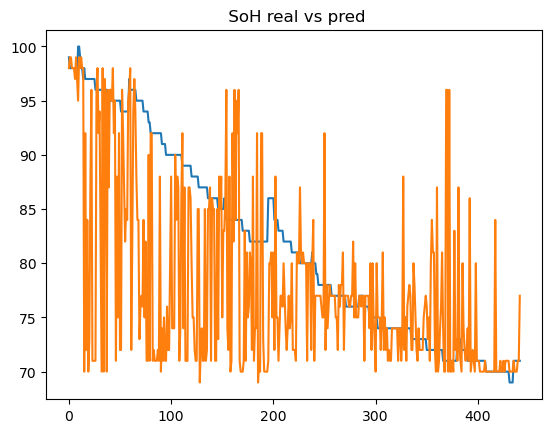

In [159]:
#KNeighborsTimeSeriesClassifier

padded_clf = PaddingTransformer() * KNeighborsTimeSeriesClassifier(n_neighbors=10, n_jobs=10)
padded_clf.fit(x_train, y_train)

y_pred = padded_clf.predict(x_test)

print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()


0.015976269759935244
1.4833333333333334
1.4833333333333334


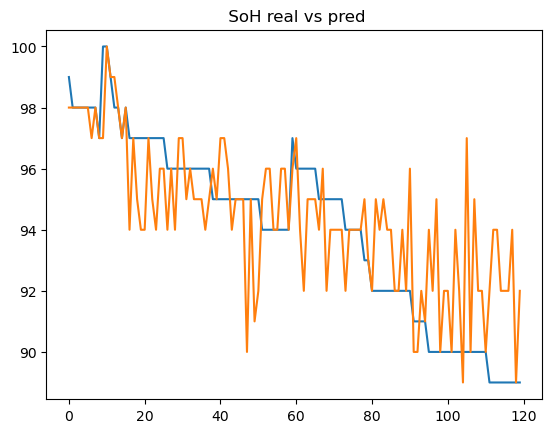

In [108]:
# random interval

#padded_clf = PaddingTransformer() * KNeighborsTimeSeriesClassifier(n_neighbors=2, n_jobs=10)
padded_clf = PaddingTransformer() * RandomIntervalClassifier(n_intervals=5)
padded_clf.fit(x_train, y_train)

y_pred = padded_clf.predict(x_test)

print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(np.mean(np.abs(y_test - y_pred)))

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()

2024-06-03 12:36:22.811074: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 12:36:22.833245: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 12:36:23.374350: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-03 12:36:26.968785: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0.16330164428189134
12.715686274509803


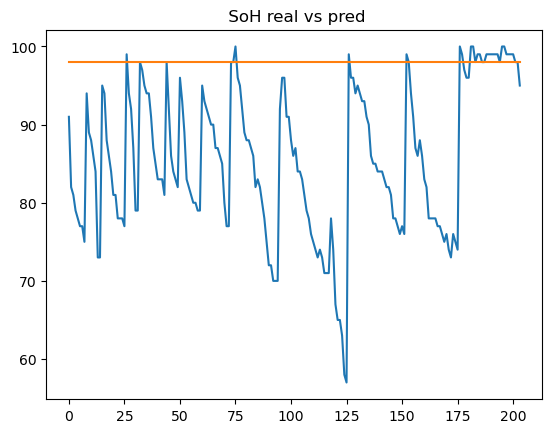

In [9]:
#cnn = PaddingTransformer() *CNNClassifier(n_epochs=500,batch_size=16) 
cnn = CNNClassifier(n_epochs=500,batch_size=16) 
cnn.fit(x_train, y_train)

y_pred = cnn.predict(x_test)

print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()

In [ ]:

# import datetime
# import numpy as np
# import pandas as pd
# from scipy.io import loadmat
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# from sklearn import metrics
# import matplotlib.pyplot as plt
# import seaborn as sns

# def load_data(battery):
#   mat = loadmat('/home/apetrella/Workspace/battery_pinn/dataset/Nasa/5. Battery Data Set/1. BatteryAgingARC-FY08Q4/'+ battery +'.mat')
#   print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
#   counter = 0
#   dataset = []
#   capacity_data = []
  
#   for i in range(len(mat[battery][0, 0]['cycle'][0])):
#     row = mat[battery][0, 0]['cycle'][0, i]
#     if row['type'][0] == 'discharge':
#       ambient_temperature = row['ambient_temperature'][0][0]
#       date_time = datetime.datetime(int(row['time'][0][0]),
#                                int(row['time'][0][1]),
#                                int(row['time'][0][2]),
#                                int(row['time'][0][3]),
#                                int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
#       data = row['data']
#       capacity = data[0][0]['Capacity'][0][0]
#       for j in range(len(data[0][0]['Voltage_measured'][0])):
#         voltage_measured = data[0][0]['Voltage_measured'][0][j]
#         current_measured = data[0][0]['Current_measured'][0][j]
#         temperature_measured = data[0][0]['Temperature_measured'][0][j]
#         current_load = data[0][0]['Current_load'][0][j]
#         voltage_load = data[0][0]['Voltage_load'][0][j]
#         time = data[0][0]['Time'][0][j]
#         dataset.append([counter + 1, ambient_temperature, date_time, capacity,
#                         voltage_measured, current_measured,
#                         temperature_measured, current_load,
#                         voltage_load, time])
#       capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
#       counter = counter + 1
#   print(dataset[0])
#   return [pd.DataFrame(data=dataset,
#                        columns=['cycle', 'ambient_temperature', 'datetime',
#                                 'capacity', 'voltage_measured',
#                                 'current_measured', 'temperature_measured',
#                                 'current_load', 'voltage_load', 'time']),
#           pd.DataFrame(data=capacity_data,
#                        columns=['cycle', 'ambient_temperature', 'datetime',
#                                 'capacity'])]
# dataset, capacity = load_data('B0005')
# pd.set_option('display.max_columns', 10)
# print(dataset)